# Optimization of CHSH Nonlocality

This notebook considers the CHSH scenario where the entangled state $\rho^{AB}$ is prepared and distributed to two non-signaling measurement nodes that apply dichotomic observables $A_x$ and $B_y$.
Here $x,y\in\{0,1\}$ and $|\langle A_x B_y\rangle|\leq1$.
The bipartite correlator is constructed as

$$
\langle A_x B_y\rangle = \text{Tr}[A_x \otimes B_x \rho^{AB}].
$$

The CHSH inequality is then defined as,

$$
S_{CHSH} := \langle A_0B_0\rangle + \langle A_0 B_1\rangle + \langle A_1 B_0 \rangle - \langle A_1 B_1 \rangle \leq 2.
$$

For quantum systems $S_{CHSH}\leq2\sqrt{2}$.

The goal of this demo is to use `qnetvo` to find preparation and measurement settings that achieve the maximal quantum violation of the CHSH inequality.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

import qnetvo as qnet

## CHSH Ansatz

We now use `qnetvo` to create arbitrary preparation and measurement node ansatzes and combine them to create the `chsh_ansatz`.

In [2]:
prep_nodes = [
    qnet.PrepareNode(1, [0,1], qml.ArbitraryStatePreparation, 6)
]
meas_nodes = [
    qnet.MeasureNode(2, 2, [0], qml.ArbitraryUnitary, 3),
    qnet.MeasureNode(2, 2, [1], qml.ArbitraryUnitary, 3),
]

chsh_ansatz = qnet.NetworkAnsatz(prep_nodes, meas_nodes)
chsh_ansatz_shots = qnet.NetworkAnsatz(prep_nodes, meas_nodes, dev_kwargs={
    "name" : "default.qubit",
    "shots" : 2000,
})

## CHSH Cost

The cost function is simply $-S_{CHSH}$.
Minimizing this quantity is equivalent to maximizing the the CHSH inequality.
The cost function is conveniently provided by `qnetvo`.
The differentation method must be specified during cost function creation.
We construct two cost functions, one using backpropagation and the other the parameter-shift rule.

In [3]:
# backpropagation cost function
chsh_cost_bp = qnet.chsh_inequality_cost_fn(chsh_ansatz)

# parameter-shift rule cost function
chsh_cost_ps = qnet.chsh_inequality_cost_fn(chsh_ansatz_shots, diff_method="parameter-shift")

## Optimizing the CHSH Violation

### Basic Gradient Descent with Backpropagation

In the first experiment, we show a standard gradient descent optimization using backpropagation.

In [4]:
np.random.seed(66)
settings = chsh_ansatz.rand_network_settings()

chsh_bp_opt_dict = qnet.gradient_descent(
    chsh_cost_bp,
    settings,
    step_size=0.4,
    sample_width=1,
    num_steps=20,
    verbose=False
)

print("max chsh score: ", chsh_bp_opt_dict["opt_score"])
print("theoretical score: ", 2*np.sqrt(2))

max chsh score:  2.8259651165075415
theoretical score:  2.8284271247461903


### Natural Gradient Descent with Backpropagation

Next, we show how the [natural gradient](https://arxiv.org/abs/1909.02108) can be applied.
`qnetvo` provides a special natural gradient function constructor for the CHSH inequality.

In [5]:
chsh_ng = qnet.parallel_chsh_grad_fn(chsh_ansatz, natural_grad=True)

np.random.seed(66)
settings = chsh_ansatz.rand_network_settings()

chsh_ng_bp_opt_dict = qnet.gradient_descent(
    chsh_cost_bp,
    settings,
    step_size=0.09,
    sample_width=1,
    num_steps=20,
    grad_fn=chsh_ng,
    verbose=False
)

print("max chsh nat grad score: ", chsh_ng_bp_opt_dict["opt_score"])
print("theoretical score: ", 2*np.sqrt(2))

max chsh nat grad score:  2.827154047358423
theoretical score:  2.8284271247461903


### Basic Gradient Descent with Parameter-Shift Rule

In [6]:
np.random.seed(66)
settings = chsh_ansatz_shots.rand_network_settings()

chsh_ps_opt_dict = qnet.gradient_descent(
    chsh_cost_ps,
    settings,
    step_size=0.4,
    sample_width=1,
    num_steps=20,
    verbose=False
)

print("max chsh score: ", chsh_ps_opt_dict["opt_score"])
print("theoretical score: ", 2*np.sqrt(2))

max chsh score:  2.78
theoretical score:  2.8284271247461903


### Plotting Optimizations

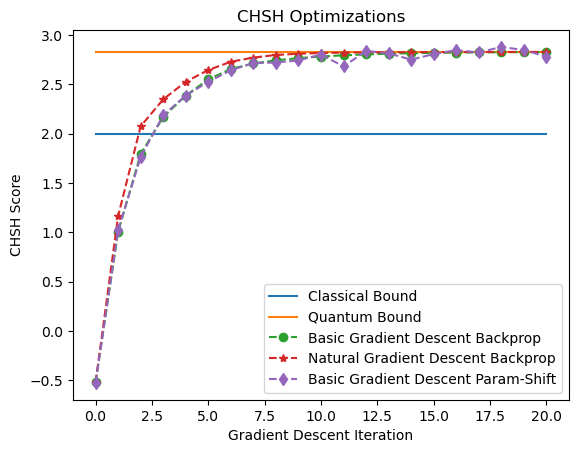

In [7]:
# Plot the individual observables
samples = chsh_bp_opt_dict["samples"]
plt.plot(samples, [2]*len(samples), label = "Classical Bound")
plt.plot(samples, [2*np.sqrt(2)]*len(samples), label = "Quantum Bound")
plt.plot(samples, chsh_bp_opt_dict["scores"], "o--", label = "Basic Gradient Descent Backprop")
plt.plot(samples, chsh_ng_bp_opt_dict["scores"], "*--", label = "Natural Gradient Descent Backprop")
plt.plot(samples, chsh_ps_opt_dict["scores"], "d--", label = "Basic Gradient Descent Param-Shift")

plt.title("CHSH Optimizations")
plt.xlabel("Gradient Descent Iteration")
plt.ylabel("CHSH Score")
plt.legend()
plt.show()